In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,f1_score,classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, FunctionTransformer

import mlflow


In [43]:
df=pd.read_csv('data/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [45]:
# df.isin([np.inf,-np.inf]).sum()
# np.isinf(df[num_feats]).values.sum()

In [46]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


<Axes: xlabel='loan_status'>

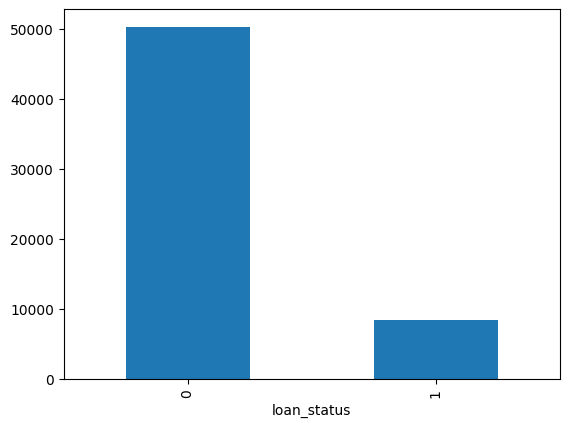

In [47]:
df['loan_status'].value_counts().plot(kind='bar')

In [48]:
num_feats=['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
target=['loan_status']
nonnum_feats=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']

for nonnum_feat in nonnum_feats:
    print(df[nonnum_feat].value_counts())

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64
loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64
cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64


# ToDO:
* Can try 1hot encoding for homeownership
* 1hot for loan_intent

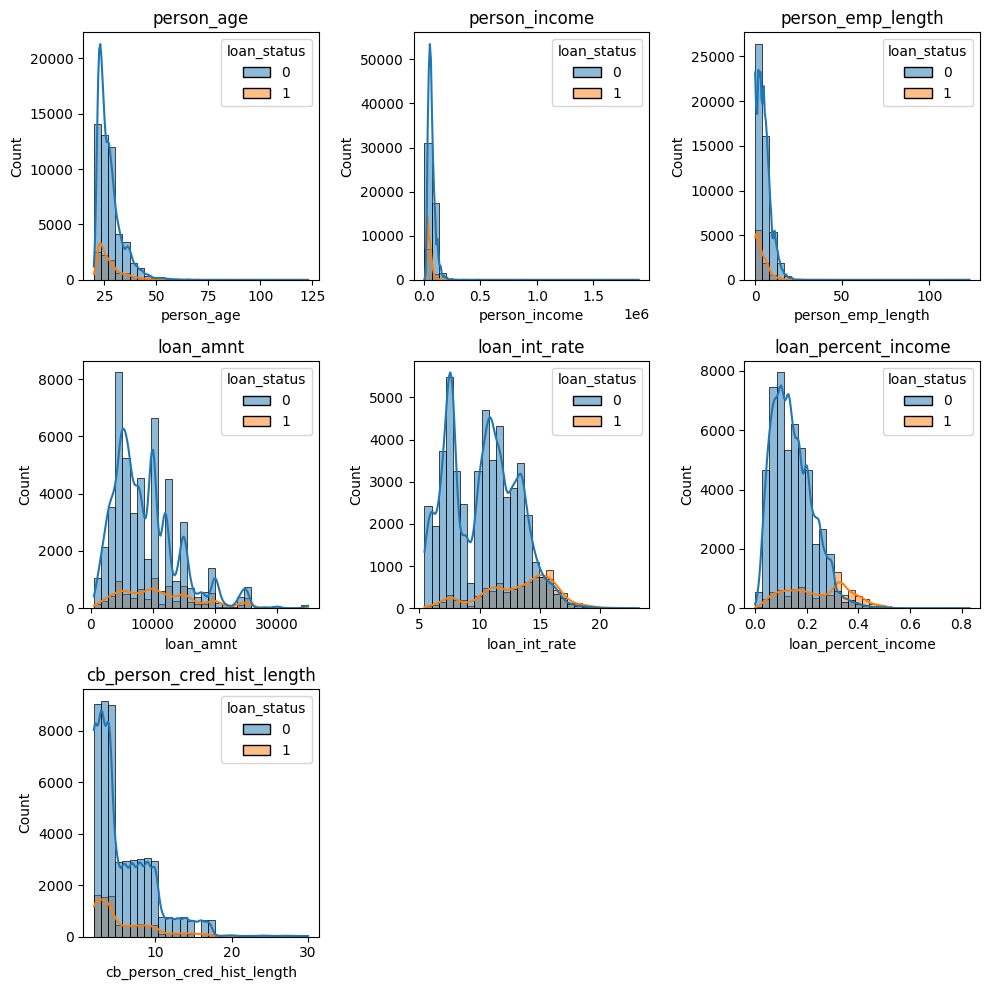

In [49]:
plt.figure(figsize=(10,10))
for pltinx,numfeat in enumerate(num_feats):
    plt.subplot(3,3,pltinx+1)
    sns.histplot(data=df,x=numfeat,hue='loan_status',kde=True,bins=30)
    plt.title(numfeat)

plt.tight_layout()

In [50]:
logtrans_feats=['person_age','person_income','person_emp_length','loan_amnt','loan_percent_income','cb_person_cred_hist_length']
# df[logtrans_feats]=np.log1p(df[logtrans_feats])

In [51]:
# df[num_feats].boxplot()
# plt.xticks(rotation=90)

In [52]:
# df.groupby(['loan_status','person_home_ownership'])['id'].agg('count').reset_index()

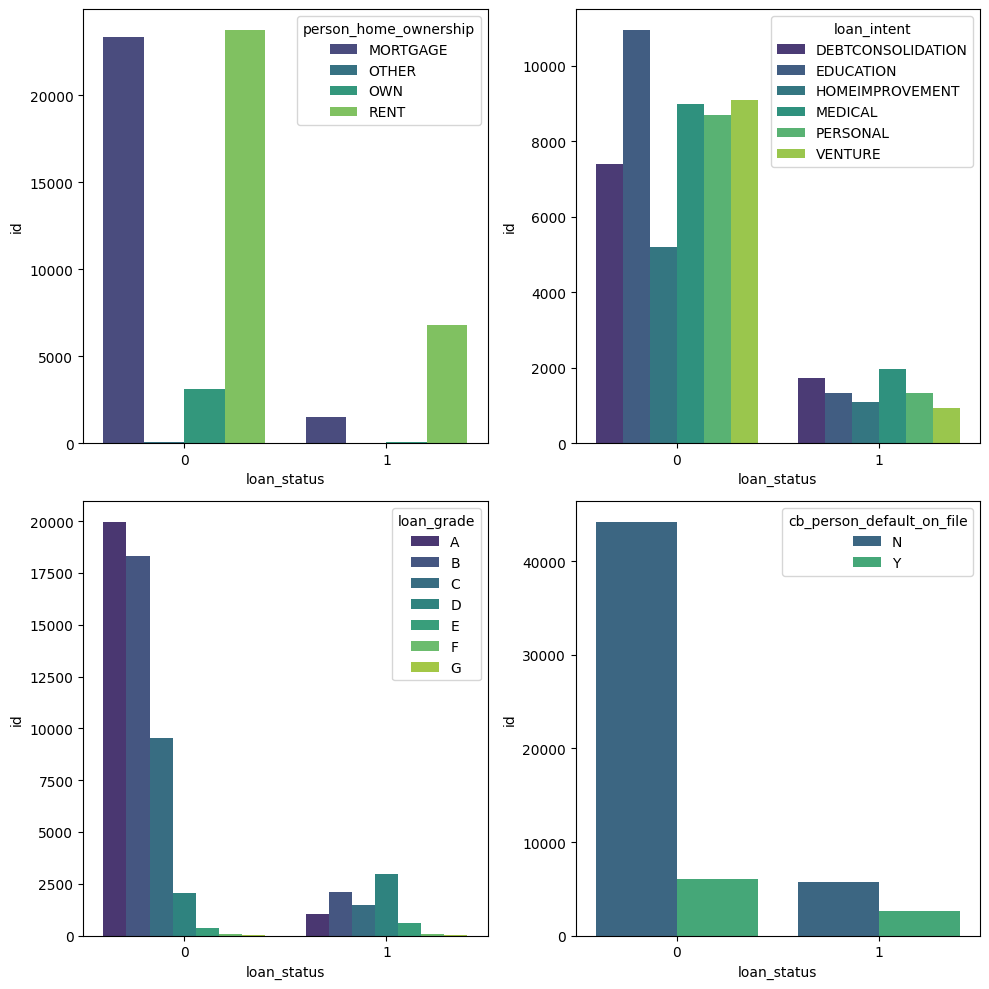

In [53]:
plt.figure(figsize=(10,10))
for inx,f in enumerate(nonnum_feats):
    plt.subplot(2,2,inx+1)
    sns.barplot(data=df.groupby(['loan_status',f])['id'].\
                agg('count').reset_index(),x='loan_status',y='id',hue=f,palette='viridis')
    
plt.tight_layout()
plt.show()

In [64]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [55]:
num_cols=['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length','person_home_ownership','loan_grade','cb_person_default_on_file']
cat_cols=['loan_intent']

In [57]:
X=df.drop(columns=['id','loan_status'])
y=df['loan_status']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [58]:

loangrade_map={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
persondefault_map={'N':0,'Y':1}
homeownership_map={'OTHER':0,'RENT':1,'MORTGAGE':2,'OWN':3}

def custom_ordinalencoding(df):
    df['loan_grade']=df['loan_grade'].replace(loangrade_map)
    df['cb_person_default_on_file']=df['cb_person_default_on_file'].replace(persondefault_map)
    df['person_home_ownership']=df['person_home_ownership'].replace(homeownership_map)

    return df

X_train=custom_ordinalencoding(X_train)

coltrans1=ColumnTransformer(transformers=[
    ('LogTransform',FunctionTransformer(np.log1p,feature_names_out='one-to-one'),logtrans_feats),
],verbose_feature_names_out=False,remainder='passthrough')
# coltrans1.set_output(transform='pandas')

num_pipeline=Pipeline(steps=[
    ('logtrans',coltrans1),
    ('impute',SimpleImputer(strategy='mean')),
    ('scale',StandardScaler())
])

cat_pipeline=Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',drop='first')),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

coltrans2=ColumnTransformer(transformers=[
    ('NumericalPipeline',num_pipeline,num_cols),
    ('CategoricalPipeline',cat_pipeline,cat_cols)
],verbose_feature_names_out=False)

X_train=coltrans2.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=coltrans2.get_feature_names_out())

X_train.head()


   person_age  person_income  person_emp_length  loan_amnt  \
0    1.191423       1.702502           1.887515   1.779020   
1    0.184424       0.557741          -0.486238   1.049653   
2    0.876339       3.127087          -0.486238   1.049653   
3    2.416845       0.274428           1.062084  -0.718433   
4   -0.828946       0.324252          -1.899065  -1.001316   

   loan_percent_income  cb_person_cred_hist_length  loan_int_rate  \
0             0.380771                    0.808994      -1.241139   
1             0.489540                    0.034481       1.738724   
2            -1.122875                    1.192312       0.761936   
3            -1.000828                    1.784765       0.266942   
4            -1.122875                   -1.289557      -1.241139   

   person_home_ownership  loan_grade  cb_person_default_on_file  \
0               0.787113   -1.021619                  -0.418594   
1               0.787113    2.805914                   2.388949   
2          

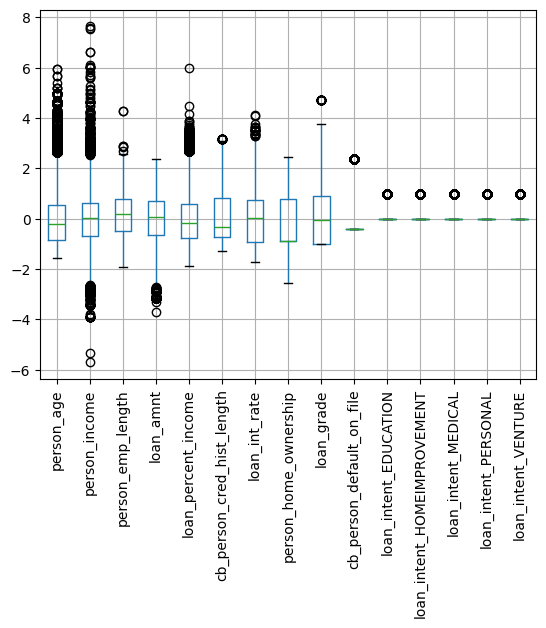

In [60]:
X_train.boxplot()
plt.xticks(rotation=90)
plt.show()

Machine Learning

Preparing Test data

In [62]:
X_test=custom_ordinalencoding(X_test)
X_test=coltrans2.transform(X_test)

In [63]:

mlflow.set_experiment('LoanApp')

with mlflow.start_run():
    logreg=LogisticRegression().fit(X_train,y_train)

    tr_pred=logreg.predict(X_train)

    
    te_pred=logreg.predict(X_test)

    clfrep_train=classification_report(y_train,tr_pred)
    clfrep_test=classification_report(y_test,te_pred)
    
    tr_acc=accuracy_score(y_train,tr_pred)
    tr_prec=precision_score(y_train,tr_pred)
    tr_f1=f1_score(y_train,tr_pred)

    te_acc=accuracy_score(y_test,te_pred)
    te_prec=precision_score(y_test,te_pred)
    te_f1=f1_score(y_test,te_pred)

    print('Train report')
    print(clfrep_train)

    print('Test rep')
    print(clfrep_test)

    mlflow.log_metric('tr acc',tr_acc)
    mlflow.log_metric('tr prec',tr_prec)
    mlflow.log_metric('tr f1',tr_f1)

    mlflow.log_metric('te acc',te_acc)
    mlflow.log_metric('te prec',te_prec)
    mlflow.log_metric('te f1',te_f1)

    mlflow.set_tag('model prop','Base logreg')

    

Train report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     40189
           1       0.76      0.47      0.58      6727

    accuracy                           0.90     46916
   macro avg       0.84      0.72      0.76     46916
weighted avg       0.89      0.90      0.89     46916

Test rep
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10106
           1       0.75      0.49      0.59      1623

    accuracy                           0.91     11729
   macro avg       0.84      0.73      0.77     11729
weighted avg       0.90      0.91      0.90     11729



In [ ]:
# mlflow.set_experiment('LoanApp')

# with mlflow.start_run():
#     logreg=LogisticRegression(class_weight='balanced').fit(X_train,y_train)

#     tr_pred=logreg.predict(X_train)
#     te_pred=logreg.predict(X_test)

#     clfrep_train=classification_report(y_train,tr_pred)
#     clfrep_test=classification_report(y_test,te_pred)
    
#     tr_acc=accuracy_score(y_train,tr_pred)
#     tr_prec=precision_score(y_train,tr_pred)
#     tr_f1=f1_score(y_train,tr_pred)

#     te_acc=accuracy_score(y_test,te_pred)
#     te_prec=precision_score(y_test,te_pred)
#     te_f1=f1_score(y_test,te_pred)

#     print('Train report')
#     print(clfrep_train)

#     print('Test rep')
#     print(clfrep_test)

#     mlflow.log_metric('tr acc',tr_acc)
#     mlflow.log_metric('tr prec',tr_prec)
#     mlflow.log_metric('tr f1',tr_f1)

#     mlflow.log_metric('te acc',te_acc)
#     mlflow.log_metric('te prec',te_prec)
#     mlflow.log_metric('te f1',te_f1)

#     mlflow.set_tag('model prop','Weighted logreg')

    

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# rfparameters={'max_depth':np.arange(5,80,10),'n_estimators':np.arange(10,400,50)}

# rf=RandomForestClassifier(random_state=3)
# hypersearch=RandomizedSearchCV(rf,rfparameters,scoring='f1',cv=5)
# hypersearch.fit(X_train,y_train)

# plt.plot(np.arange(len(hypersearch.cv_results_['mean_test_score'])),hypersearch.cv_results_['mean_test_score'])
# plt.ylabel('Mean f1 score')


    

In [ ]:
# # hypersearch_bestmodel=hypersearch.best_estimator_
# mlflow.set_experiment('LoanApp')

# with mlflow.start_run():
#     tr_pred=hypersearch.best_estimator_.predict(X_train)
#     te_pred=hypersearch.best_estimator_.predict(X_test)

#     clfrep_train=classification_report(y_train,tr_pred)
#     clfrep_test=classification_report(y_test,te_pred)
    
#     tr_acc=accuracy_score(y_train,tr_pred)
#     tr_prec=precision_score(y_train,tr_pred)
#     tr_f1=f1_score(y_train,tr_pred)

#     te_acc=accuracy_score(y_test,te_pred)
#     te_prec=precision_score(y_test,te_pred)
#     te_f1=f1_score(y_test,te_pred)

#     print('Train report')
#     print(clfrep_train)

#     print('Test rep')
#     print(clfrep_test)

#     mlflow.log_metric('tr acc',tr_acc)
#     mlflow.log_metric('tr prec',tr_prec)
#     mlflow.log_metric('tr f1',tr_f1)

#     mlflow.log_metric('te acc',te_acc)
#     mlflow.log_metric('te prec',te_prec)
#     mlflow.log_metric('te f1',te_f1)

#     mlflow.sklearn.log_model(hypersearch.best_estimator_,'RF best estimator')

#     mlflow.set_tag('model prop','Random Forest Classifier')

In [36]:
# import pickle

# # save the iris classification model as a pickle file
# model_pkl_file = "loanapp_rf.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(hypersearch.best_estimator_, file)


In [38]:
# # save the iris classification model as a pickle file
# coltrans_pkl_file = "loanapp_coltransformer.pkl"  

# with open(coltrans_pkl_file, 'wb') as file:  
#     pickle.dump(coltrans2, file)